# The Echo Chamber Effect - A Case Study (provisional title)

## Milestone 2

In this notebook we will download a small sample of the Reddit dataset for the first time and perform some basic statistics on it.

We will also load the two recommended NLP libraries and try them out to see how they work and to which extent we can take advantage of them.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
%matplotlib inline

import findspark
findspark.init(r'C:\Spark\spark-2.3.2-bin-hadoop2.7')
#findspark.init('/Users/vikalpkamdar/opt/spark')
#findspark.init()
findspark.find()

from datetime import datetime
from matplotlib import pyplot as plt
from pyspark.sql import *
from pyspark.sql.functions import *

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlc = SQLContext(sc)

In [2]:
DATA_DIR = './data/'

We took a tiny slice of the 2017 data from the cluster, compressed it into a parquet file and downloaded to our local machines in order to mess with it. If succesful we may try with a bigger and more representative sample (e.g. with data from all subreddits and all years sampled randomly but maintaining relative size bewteen subreddits)

In [3]:
df_spark = sqlc.read.parquet(DATA_DIR + "sliced_2017_posts.parquet")

Firstly we show the column names of the spark data frame and the first row in order to analize how the data frame is structured, the differents columns and its meaning:

In [4]:
df_spark.columns

['author',
 'author_flair_css_class',
 'author_flair_text',
 'body',
 'controversiality',
 'created_utc',
 'distinguished',
 'edited',
 'gilded',
 'id',
 'link_id',
 'parent_id',
 'retrieved_on',
 'score',
 'stickied',
 'subreddit',
 'subreddit_id']

In [5]:
df_spark.show(2)

+--------+----------------------+--------------------+-----------+----------------+-----------+-------------+------+------+-------+---------+---------+------------+-----+--------+---------+------------+
|  author|author_flair_css_class|   author_flair_text|       body|controversiality|created_utc|distinguished|edited|gilded|     id|  link_id|parent_id|retrieved_on|score|stickied|subreddit|subreddit_id|
+--------+----------------------+--------------------+-----------+----------------+-----------+-------------+------+------+-------+---------+---------+------------+-----+--------+---------+------------+
|shawentq|                  noob|redditor for 13 days|      Good.|               0| 1484803726|         null| false|     0|dcm915l|t3_5ormfl|t3_5ormfl|  1486172193|    2|   false|  Bitcoin|    t5_2s3qj|
|  kerd0z|  NHL-SJS1-sheet1-c...|           SJS - NHL|What now?! |               0| 1484803727|         null| false|     0|dcm915m|t3_5otvnh|t3_5otvnh|  1486172193|    2|   false|   hockey

So, we explain the meaning of each column here:
* 'author': The name of the user who have written the comment. -> In the first row we see that the user is "shawentq".
* 'author_flair_css_class': CSS class, for defining the style of the 'author_flair_text'.
* 'author_flair_text':  It is a tag associated to your username and which is only visible in the current subreddit. 
* 'body': The content of the comment.
* 'controversiality': When its value is 1, the comment has lot of comments and roughly the same amount of down votes and up votes. https://www.reddit.com/r/redditdev/comments/29i58s/reddit_change_api_availability_controversiality/
* 'created_utc': Timestamp of the comment creation date.
* 'distinguished': If a comment is distinguished, this mean that a reddit moderator have highlighted it (A comment could be distinguished by a moderator or an admin).
* 'edited': Variable that indicates if a comment have been edited or not. If it has not been edited the variable values is False, else its value is the timestap of the last edition.
* 'gilded': When its value is 1, that means that a premium user gave to the author reddit gold (a week of reddit premium). https://www.reddit.com/premium/; https://www.reddit.com/coins/
* 'id': Id of the comment.
* 'link_id': Id of the link (similar to post) this comment is anwering to.
* 'parent_id': Id of the post this comment is anwering to.
* 'retrieved_on': Timestamp of the comment retrieval (to this data set).
* 'score': Up votes minous down votes that users have given to the comment (Reddit use to ofuscates this value when the comment has lot of votes in order to avoid external bots incursions. It is called "vote fuzzing", https://www.reddit.com/r/firstdayontheinternet/comments/30b44n/could_someone_explain_how_the_reddit_karma_system/).
* 'stickied': Boolean variable; When a comment is stickied (by a moderator), every user who enter to the post is seeing the comment right below the post.
* 'subreddit': Subreddit name where the post have been posted (a subreddit is community within reddit). -> In the first row we see that the user is "bitcoin".
* 'subreddit_id': Id of the subreddit.

Now we continue the analysis by seeing the types of each column:

In [6]:
df_spark.distinct()

DataFrame[author: string, author_flair_css_class: string, author_flair_text: string, body: string, controversiality: bigint, created_utc: bigint, distinguished: string, edited: string, gilded: bigint, id: string, link_id: string, parent_id: string, retrieved_on: bigint, score: bigint, stickied: boolean, subreddit: string, subreddit_id: string]

And the different values of some specific columns (it has no sense to print all the values of author, body, etc columns):

In [7]:
df_spark[['controversiality']].distinct().show(4)

+----------------+
|controversiality|
+----------------+
|               0|
|               1|
+----------------+



In [8]:
df_spark[['distinguished']].distinct().show(4)

+-------------+
|distinguished|
+-------------+
|         null|
|    moderator|
|        admin|
+-------------+



In [9]:
df_spark[['edited']].distinct().show(2)

+----------+
|    edited|
+----------+
|1484815596|
|1484852244|
+----------+
only showing top 2 rows



In [10]:
df_spark[['link_id']].distinct().orderBy(desc("link_id")).show(3)

+--------+
| link_id|
+--------+
|t3_zwi2z|
|t3_u3i7o|
|t3_ohcwm|
+--------+
only showing top 3 rows



In [11]:
df_spark.filter('parent_id != link_id').show(2)

+-----------------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+-------+---------+----------+------------+-----+--------+---------+------------+
|           author|author_flair_css_class|author_flair_text|                body|controversiality|created_utc|distinguished|edited|gilded|     id|  link_id| parent_id|retrieved_on|score|stickied|subreddit|subreddit_id|
+-----------------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+-------+---------+----------+------------+-----+--------+---------+------------+
|forks_n_spoons_69|                  null|             null|You were- are- th...|               0| 1484803727|         null| false|     0|dcm9167|t3_5opqck|t1_dclgl1m|  1486172193|    1|   false|AskReddit|    t5_2qh1i|
|Concrete-cannibal|                  null|             null|Basically after t...|               0| 1484803729|         null|

We observe that the number of samples is very high even with this sample of the whole data set:

In [12]:
df_spark.count()

7896283

In [13]:
df_spark[['score']].orderBy(asc('score')).show(3)

+-----+
|score|
+-----+
|-1554|
| -904|
| -867|
+-----+
only showing top 3 rows



In [14]:
df_spark[['score']]

DataFrame[score: bigint]

In [15]:
df_spark[['subreddit_id']].distinct().count()

40799

In [16]:
df_spark.filter('controversiality = 1') #.count()

DataFrame[author: string, author_flair_css_class: string, author_flair_text: string, body: string, controversiality: bigint, created_utc: bigint, distinguished: string, edited: string, gilded: bigint, id: string, link_id: string, parent_id: string, retrieved_on: bigint, score: bigint, stickied: boolean, subreddit: string, subreddit_id: string]

### To Pandas

In [17]:
#df = df_spark.sample(False,0.1).toPandas()

In [18]:
df_pd = pd.read_parquet(DATA_DIR + "sliced_2017_posts.parquet") #conda install pyarrow #We get an error if we try to transform the spark dataframe

In [19]:
df_pd.head(2)

,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,edited,gilded,id,link_id,parent_id,retrieved_on,score,stickied,subreddit,subreddit_id
0,Godcon,None,None,Do you buy the minis yourself and include that...,0,1483228800,None,false,0,dbumnq3,t3_5l9ny9,t1_dbukpfs,1485679711,2,False,minipainting,t5_2scss
1,Fleetthrow,None,None,"Can I ask where you work now and what you do, ...",0,1483228800,None,false,0,dbumnq6,t3_5l0tz4,t1_dbuksbh,1485679711,1,False,gis,t5_2qmpb


In [20]:
df_pd[['controversiality', 'distinguished', 'edited', 'parent_id']].values

array([[0, None, 'false', 't1_dbukpfs'],
       [0, None, 'false', 't1_dbuksbh'],
       [0, None, 'false', 't3_5lb5aj'],
       ...,
       [0, None, 'false', 't1_dd6083m'],
       [0, None, 'false', 't3_5r7j8k'],
       [0, None, 'false', 't1_dd5jifl']], dtype=object)

In [21]:
df_pd.shape

(7896283, 17)

In [22]:
len(df_pd['id'].unique())

7896283

In [23]:
#df_thresholded = df.reset_index()[df['subreddit'].value_counts() <10]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB749CE400>]],
      dtype=object)

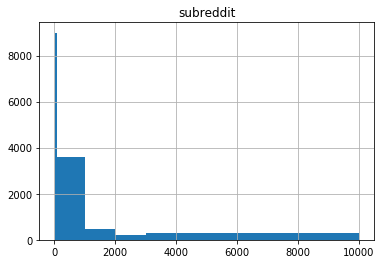

In [24]:
df_pd['subreddit'].value_counts().to_frame().hist(bins=[10,100,1000,2000,3000,10000])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB003050F0>]],
      dtype=object)

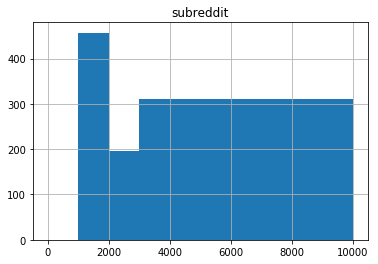

In [25]:
df_pd['subreddit'].value_counts().to_frame()[df_pd['subreddit'].value_counts() > 1000].hist(bins=[10,100,1000,2000,3000,10000])

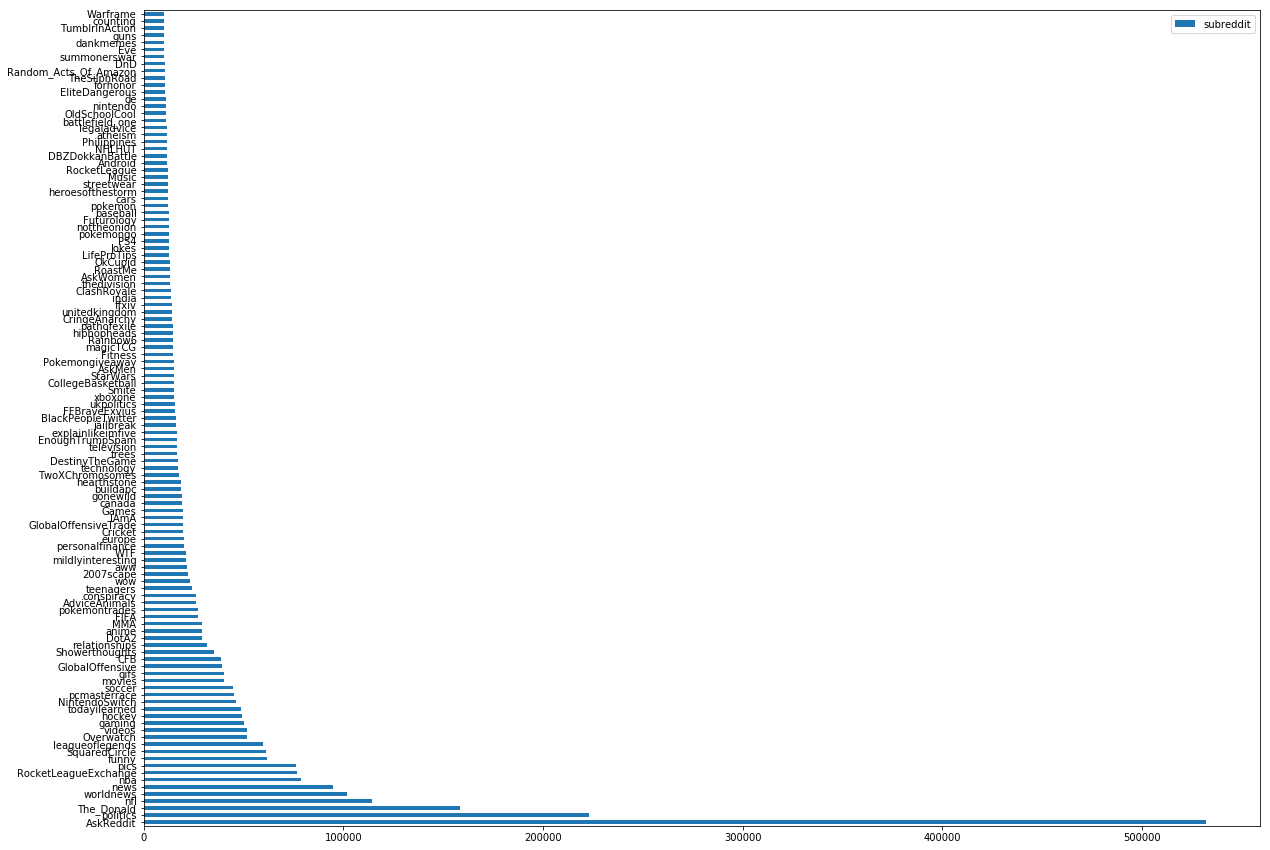

In [26]:
df_pd['subreddit'].value_counts().to_frame()[df_pd['subreddit'].value_counts() > 10000].plot(kind='barh', figsize=(20,15))

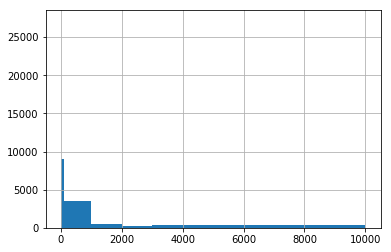

In [27]:
df_pd['subreddit'].value_counts().hist(bins=[0,10,100,1000,2000,3000,10000])

In [28]:
df_pd[df_pd['subreddit'] == 'CloudPorn']

,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,edited,gilded,id,link_id,parent_id,retrieved_on,score,stickied,subreddit,subreddit_id
1435734,[deleted],None,None,[removed],0,1484046309,None,false,0,dc8kecc,t3_5l3j52,t3_5l3j52,1485928415,1,False,CloudPorn,t5_2srcp
1942374,[deleted],None,None,[removed],0,1484312302,None,false,0,dcdgxk0,t3_5nmove,t3_5nmove,1486014964,1,False,CloudPorn,t5_2srcp
5354331,[deleted],None,None,[removed],0,1484079427,None,false,0,dc97pof,t3_5itsz5,t3_5itsz5,1485939921,1,False,CloudPorn,t5_2srcp


In [29]:
df_pd.dtypes

author                    object
author_flair_css_class    object
author_flair_text         object
body                      object
controversiality           int64
created_utc                int64
distinguished             object
edited                    object
gilded                     int64
id                        object
link_id                   object
parent_id                 object
retrieved_on               int64
score                      int64
stickied                    bool
subreddit                 object
subreddit_id              object
dtype: object

In [30]:
# nº of subreddits
# relative sizes
# some graphs with posting frequency
# nº of posts per user 

### Statistics on the cluster

In this part we show what we can do with a bigger sample. We have sampled the 10% of the data we are going to use, that is, comments from 2012 to 2016 (included). In total the dataset weights 387.5GB compressed (in parquet files) and 1.1 TB uncompressed so with the 10% of that we are working with 38.75GB (compressed in parquet files), what we think is big enough. 

First we compute the number of removed comments (We now that a comment has been removed when its body contains "[deleted]")

In [31]:
total_n_comments = df_spark.count()
total_n_comments

7896283

In [32]:
n_deleted_comments = df_spark.filter('body = "[deleted]"').count()
n_deleted_comments 

327577

In [33]:
percentage_deleted_comments = 100 * n_deleted_comments  / total_n_comments
percentage_deleted_comments

4.148496197514704

And the number of comments posted by removed users (Users who have removed their account after post the comment)

In [34]:
comments_by_removed_users = df_spark.filter('author = "[deleted]"').count()
comments_by_removed_users

575673

In [35]:
percentage_by_dl_user = 100 * comments_by_removed_users / total_n_comments
percentage_by_dl_user

7.290430193548028

Now we see the total number of controversial comments and the percentage of them:

In [36]:
n_controversial_comments = df_spark.filter('controversiality = 1').count()
n_controversial_comments

151363

In [37]:
perc_controversial_comments = 100 * n_controversial_comments / total_n_comments
perc_controversial_comments

1.9168892502966268

Having easily computed this percentages, we now get a dataframe with the number of comments per subrredit in order to plot the distribution:

In [38]:
#Total number of subreddits:
df_spark[['subreddit']].distinct().count()

40799

In [39]:
df_subreddit_count = df_spark.groupBy('subreddit').agg(count('*')).withColumnRenamed('count(1)', 'Number of comments')
df_subreddit_count

DataFrame[subreddit: string, Number of comments: bigint]

In [40]:
df_subreddit_count.show(2)

+------------+------------------+
|   subreddit|Number of comments|
+------------+------------------+
|       anime|             29331|
|marvelheroes|               811|
+------------+------------------+
only showing top 2 rows



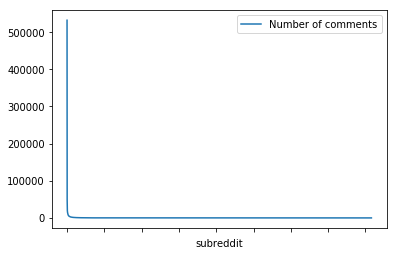

In [41]:
df_tmp = df_subreddit_count.toPandas().sort_values(by = "Number of comments", ascending = False)
df_tmp.plot(x = "subreddit", y = "Number of comments")

And the number of controversial comments per subrredit:

In [4]:
df_subreddit_count = spark.read.parquet(DATA_DIR + 'df_subreddit_count.parquet')

In [5]:
df_subreddit_count.toPandas().shape

(131028, 2)

10 most 'popular' (commented) subbreddits

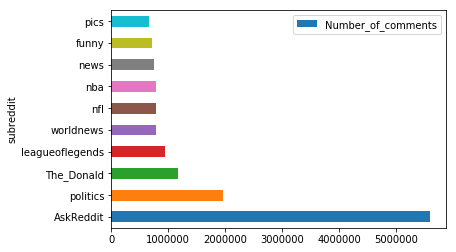

In [6]:
df_tmp = df_subreddit_count.toPandas().sort_values(by = "Number_of_comments", ascending = False).iloc[:10,:]
df_tmp.plot(kind='barh',x = "subreddit", y = "Number_of_comments")

10 least popular subreddits

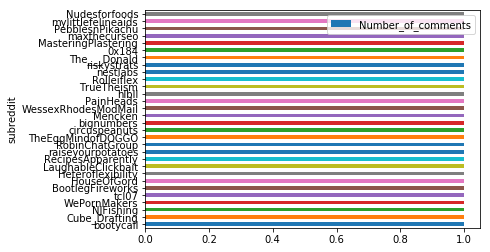

In [9]:
df_tmp = df_subreddit_count.toPandas().sort_values(by = "Number_of_comments", ascending = True).iloc[:30,:]
df_tmp.plot(kind='barh',x = "subreddit", y = "Number_of_comments")

In [10]:
df_subreddit_count_pd = df_subreddit_count.toPandas()

In [20]:
n_subreddits_per_comment = df_subreddit_count_pd.groupby('Number_of_comments').count()

In [26]:
n_subreddits_per_comment

,subreddit
Number_of_comments,
1,52023
2,19478
3,8884
4,5233
5,3648
6,2658
7,2079
8,1832
9,1544


In [24]:
n_subreddits_per_comment.index.tolist()

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a228d56d8>]],
      dtype=object)

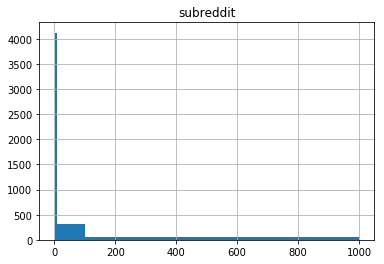

In [31]:
df_subreddit_count_pd.groupby('Number_of_comments').count().hist(bins=[1,10,100,1000])

In [42]:
df_controversial_per_subr_count = df_spark.filter('controversiality = 1').groupBy('subreddit').agg(count('*')).withColumnRenamed('count(1)', 'N controversial comments')
df_controversial_per_subr_count.show(2)

+--------------+------------------------+
|     subreddit|N controversial comments|
+--------------+------------------------+
|TrueOffMyChest|                      22|
|         anime|                     192|
+--------------+------------------------+
only showing top 2 rows



With this two data frames we can check if there exists a correlation between the percentage of controversial comments and the total number of comments; i.e if there exists a correlation between the subreddit controversiality (measured by the percentage of comments that are controversial) with the subreddit popularity (measured by the number of comments in the subreddit). 

(Note that we do the join between both data frames and then compute the percentage of controversial comments)

In [43]:
df_crr = df_controversial_per_subr_count.join(df_subreddit_count, "subreddit") 
df_crr = df_crr.select('subreddit', 'Number of comments', 100* df_crr['N controversial comments'] / df_crr['Number of comments'])
df_crr = df_crr.withColumnRenamed("Number of comments", "Popularity").withColumnRenamed("((N controversial comments * 100) / Number of comments)", "Controversiality")
df_crr.show(2)

+---------+----------+------------------+
|subreddit|Popularity|  Controversiality|
+---------+----------+------------------+
|   AdPorn|        53|3.7735849056603774|
|  Amateur|       582|0.6872852233676976|
+---------+----------+------------------+
only showing top 2 rows



In [44]:
df_crr.corr("Popularity", "Controversiality")

-0.014741586992230866

We see there is no correlation between popularity and controversiality, what could be a good factor for our analysis of the echo-chambing effect; since this mean that when a subreddit is so big, it does not implie that there would be more discussions (controversial discussions) in percentage.

At that point we look at the timeline of activity (it could be useful for relating spikes to real-life events). What we are going to do is to fix the first timestamp of our data set as the initial moment, as 0 (and the rest of the timestamp according to this fact). Finally we plot the timeline:

Note: Locally, we have loaded a sample from the dataset of January 2017

In [45]:
df_spark[['created_utc']].orderBy(asc('created_utc')).show(1)

+-----------+
|created_utc|
+-----------+
| 1483228800|
+-----------+
only showing top 1 row



In [46]:
df_spark[['created_utc']]

DataFrame[created_utc: bigint]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB6FD315C0>]],
      dtype=object)

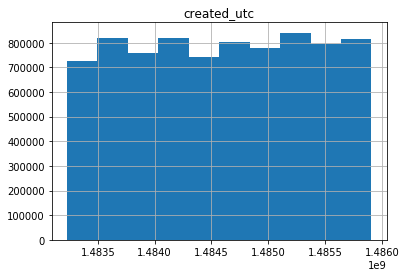

In [47]:
df_spark[['created_utc']].toPandas().hist()

In [48]:
df_spark.orderBy("id").show(2)

+----------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+-------+---------+----------+------------+-----+--------+------------+------------+
|    author|author_flair_css_class|author_flair_text|                body|controversiality|created_utc|distinguished|edited|gilded|     id|  link_id| parent_id|retrieved_on|score|stickied|   subreddit|subreddit_id|
+----------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+-------+---------+----------+------------+-----+--------+------------+------------+
|    Godcon|                  null|             null|Do you buy the mi...|               0| 1483228800|         null| false|     0|dbumnq3|t3_5l9ny9|t1_dbukpfs|  1485679711|    2|   false|minipainting|    t5_2scss|
|Fleetthrow|                  null|             null|Can I ask where y...|               0| 1483228800|         null| false|     0|dbumnq6|t

### NLP

Below are our first steps with NLP, basically trying out libraries. Here's a reference with some more libraries https://elitedatascience.com/python-nlp-libraries

#### spaCy

spaCy allows us to find named entities, thus identying the topic(s) of a post or discussion.

spaCy can be found here https://spacy.io/ with instructions for installing here https://spacy.io/usage/

In [49]:
# For the installation: Execute in the anaconda prompt:
# pip install spacy
# python -m spacy download en_core_web_sm #(With admin permissions)
import spacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm')

# Process whole documents
text = (u"When Sebastian Thrun started working on self-driving cars at "
        u"Google in 2007, few people outside of the company took him "
        u"seriously. “I can tell you very senior CEOs of major American "
        u"car companies would shake my hand and turn away because I wasn’t "
        u"worth talking to,” said Thrun, now the co-founder and CEO of "
        u"online higher education startup Udacity, in an interview with "
        u"Recode earlier this week.")
doc = nlp(text)

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

# Determine semantic similarities
doc1 = nlp(u"my fries were super gross")
doc2 = nlp(u"such disgusting fries")
similarity = doc1.similarity(doc2)
print(doc1.text, doc2.text, similarity)

Sebastian Thrun PERSON
Google ORG
2007 DATE
American NORP
Thrun PERSON
Recode ORG
earlier this week DATE
my fries were super gross such disgusting fries 0.7139702518721635


spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default model identifies a variety of named and numeric entities, including companies, locations, organizations and products. You can add arbitrary classes to the entity recognition system, and update the model with new examples.

Named Entity Recognition 101
A named entity is a "real-world object" that's assigned a name – for example, a person, a country, a product or a book title. spaCy can recognise various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn't always work perfectly and might need some tuning later, depending on your use case.

Named entities are available as the ents property of a Doc:

In [50]:
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


#### TextBlob

TextBlob allows for sentiment analysis, translation, and more

TextBlob can be found here https://textblob.readthedocs.io/en/dev/ with installation istructions here https://textblob.readthedocs.io/en/dev/install.html


In [51]:
from textblob import TextBlob

text = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists fearful of
artificial intelligence run rampant.
'''

blob = TextBlob(text)
blob.tags           # [('The', 'DT'), ('titular', 'JJ'),
                    #  ('threat', 'NN'), ('of', 'IN'), ...]

blob.noun_phrases   # WordList(['titular threat', 'blob',
                    #            'ultimate movie monster',
                    #            'amoeba-like mass', ...])

for sentence in blob.sentences:
    print(sentence.sentiment.polarity)
# 0.060
# -0.341

blob.translate(to="es")  # 'La amenaza titular de The Blob...'

0.06000000000000001
-0.34166666666666673


TextBlob("La amenaza titular de The Blob siempre me ha parecido la película definitiva.
Monstruo: una masa con forma de ameba insaciablemente hambrienta capaz de penetrar
virtualmente cualquier salvaguardia, capaz de - como un doctor condenado de forma escalofriante
Lo describe - "asimilando carne al contacto.
Las malditas comparaciones con la gelatina se condenan, es un concepto con el más
devastadora de posibles consecuencias, no a diferencia del escenario goo gris
Propuesto por teóricos tecnológicos temerosos de
La inteligencia artificial corre desenfrenada.")

We try the sentiment analysis this library offers:

The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
```
 testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
 testimonial.sentiment
 Output: Sentiment(polarity=0.39166666666666666, subjectivity=0.4357142857142857)
 testimonial.sentiment.polarity
0.39166666666666666

```

In [52]:
df_pd["Sentiment- Polarity"] = df_pd["body"]
for i in range(0,len(df_pd)):
    testimonial = TextBlob(df_pd["Sentiment- Polarity"].iloc[i])
    df_pd["Sentiment- Polarity"] = testimonial.sentiment.polarity
df_pd

TypeError: The `text` argument passed to `__init__(text)` must be a string, not <class 'numpy.float64'>

In [ ]:
a = TextBlob(df_pd["body"].iloc[0])
a.sentiment.polarity

In [53]:
df_pd["Sentiment- Polarity"] = df_pd["body"]

In [ ]:
df_pd["Sentiment- Polarity"]  = df_pd["Sentiment- Polarity"].map(lambda x: TextBlob(str(x)).sentiment.polarity)

In [ ]:
df_pd